In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from signlens.params import *
from signlens.preprocessing.glossary import load_glossary, write_glossary
from signlens.preprocessing.data import load_data_subset_csv , load_video_list_json
from signlens.preprocessing.preprocess import encode_labels, decode_labels
from signlens.model.model_utils import load_model
from utils.video_utils import process_video_to_landmarks_json, draw_landmarks_on_image

%load_ext autoreload

%autoreload 2


2024-03-27 12:10:46.927331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 12:10:50.498132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Glossary check

In [2]:
write_glossary()

Glossary already exists, are you sure you want to overwrite it? (y/n)  n


Not overwriting the glossary.


In [3]:
glossary = load_glossary()

In [4]:
len(glossary.index.unique())

250

## Convert videos to landmarks

In [5]:
videos = load_video_list_json(filter_glossary=True)
videos

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path
0,airplane,"[605, 21, 1721, 1076]",25,-1,1,10,4,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,01726,/home/bfrisque/code/benoitfrisque/signlens/raw...
1,table,"[374, 52, 810, 720]",25,-1,1,13,38,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,56556,/home/bfrisque/code/benoitfrisque/signlens/raw...
2,see,"[85, 15, 230, 192]",25,-1,1,8,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/8/8396.mp4,0,50125,/home/bfrisque/code/benoitfrisque/signlens/raw...
3,who,"[165, 4, 472, 370]",25,-1,1,14,88,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,66778,/home/bfrisque/code/benoitfrisque/signlens/raw...
4,dog,"[417, 61, 834, 720]",25,-1,1,7,38,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,1,17086,/home/bfrisque/code/benoitfrisque/signlens/raw...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,arm,"[205, 37, 489, 370]",25,-1,1,3,89,aslsignbank,val,https://aslsignbank.haskins.yale.edu/dictionar...,0,65094,/home/bfrisque/code/benoitfrisque/signlens/raw...
1472,say,"[104, 0, 528, 480]",25,-1,1,4,13,asldeafined,val,https://media.asldeafined.com/vocabulary/14687...,0,49430,/home/bfrisque/code/benoitfrisque/signlens/raw...
1473,ear,"[296, 36, 879, 720]",25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/ear.mp4,0,69306,/home/bfrisque/code/benoitfrisque/signlens/raw...
1474,closet,"[64, 14, 260, 240]",25,-1,1,6,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,11284,/home/bfrisque/code/benoitfrisque/signlens/raw...


In [6]:
video_id = '01726'
videos[videos.video_id=='01726']

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path
0,airplane,"[605, 21, 1721, 1076]",25,-1,1,10,4,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,01726,/home/bfrisque/code/benoitfrisque/signlens/raw...


In [7]:
test = videos.sample(n=500, random_state=42)

In [8]:
test['sign']

1125        on
184      white
1226     water
67        jump
220        yes
         ...  
1160    carrot
1309     store
1453    pretty
707        red
1093       cut
Name: sign, Length: 500, dtype: object

In [9]:
test['sign'].nunique()

191

In [10]:
import matplotlib.pyplot as plt

test['sign'].value_counts()

sign
no           6
underwear    6
drink        6
bed          6
many         6
            ..
head         1
say          1
jacket       1
home         1
who          1
Name: count, Length: 191, dtype: int64

(array([47.,  0., 48.,  0., 54.,  0., 23.,  0., 11.,  8.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

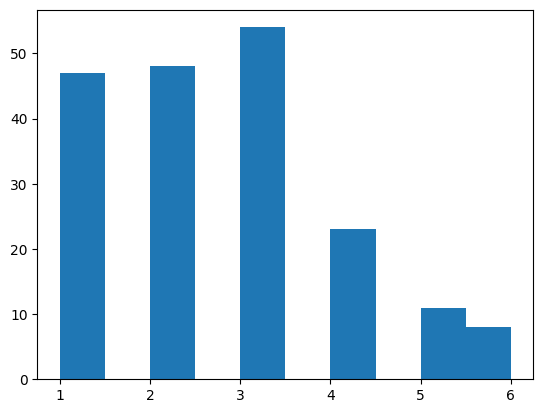

In [11]:
plt.hist(test['sign'].value_counts())

In [13]:
import concurrent.futures
from tqdm import tqdm

# Define the function to process a single video
def process_video(video_path):
    return process_video_to_landmarks_json(video_path, json_output=True, show_preview=False, save_annotated_video=False, frame_interval=1, rear_camera=True)


def process_video_parallel(video_path_df):
    # Use ThreadPoolExecutor for multithreading
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit video processing tasks
        future_to_video = {executor.submit(process_video, video_path): video_path for video_path in video_path_df}

        # Create progress bar with total number of videos
        progress_bar = tqdm(total=num_videos_to_process, desc="Processing videos")

        # Iterate over completed tasks
        for future in concurrent.futures.as_completed(future_to_video):
            # Get the video path associated with the completed task
            video_path = future_to_video[future]

            # Update progress bar
            progress_bar.update(1)

            # Get result of processing
            json_data = future.result()
            



Processing videos: 100%|███| 10/10 [47:45<00:00, 286.58s/it]                                                | 0/10 [00:00<?, ?it/s]

Processing videos:  10%|███████▌                                                                    | 1/10 [00:26<03:59, 26.66s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/50125_landmarks.json'



KeyboardInterrupt



✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/01726_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/24961_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66778_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17084_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/56556_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38336_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17086_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69261_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoit